# Group 14 - Project FP01
## Time series anomaly detection

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
import dataset as ds

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = './dataset/normal/'
ROOTDIR_DATASET_COLLISION = './dataset/collision/'

In [3]:
# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

In [4]:
# Dataset frequency
freq_01s = '0.1'
freq_001s = '0.01'
freq_0005s = '0.005'

### Data Loading

In [5]:
df_action, df, df_meta, action2int = ds.load_data(ROOTDIR_DATASET_NORMAL, freq_01s)

Loading data.
Found 31 different actions.
Loading data done.



### Feature Extraction
In this section the feature from the dataset is extracted, then the train and test data is split.

In [6]:
X_train, y_train, X_test, y_test = ds.get_train_test_data_df(df_action=df_action, df_meta=df_meta, action2int=action2int)

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 86.84294128417969 seconds ---


In [7]:
X_train, y_train_cat, X_test = ds.prepare_data_for_tf(X_train, y_train, X_test)

### Bayesian MLP for Anomaly Detection from Lab 7

In [8]:
from bayesian_model import MLPClassifier

input_shape = (X_train.values.shape[1],)
num_classes = len(y_train_cat[0])

clf = MLPClassifier(input_shape, num_classes)
clf.setup_tuner()

clf.search(X_train.values, y_train_cat)
y_test_pred = clf.predict(X_test.values)

Trial 90 Complete [00h 00m 04s]
accuracy: 0.18930041790008545

Best accuracy So Far: 0.9451302886009216
Total elapsed time: 00h 02m 10s
8/8 [==============================] - 0s 961us/step


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap="Blues",
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

def create_and_plot_cm (y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred.argmax(axis=1), labels=list(action2int.values()))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    int2action = {v: k for k, v in action2int.items()}
    seaborn_cm(cm,
                ax,
                [int2action[l] for l in action2int.values()], fontsize=8, xrotation=90)
    plt.tight_layout()

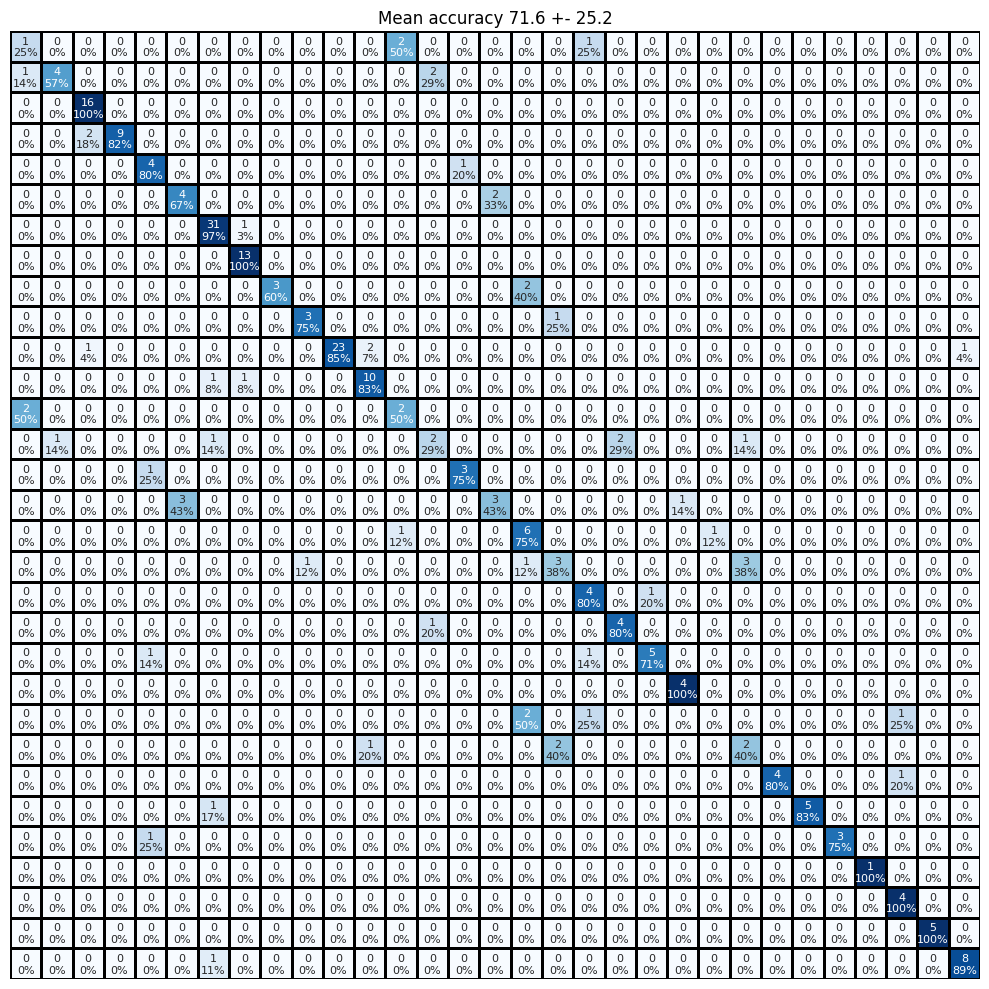

In [28]:
create_and_plot_cm(y_test_pred, y_test)